In [95]:
import numpy as np
import pandas as pd
from tqdm import tqdm


from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from nyaggle.feature.category_encoder import TargetEncoder

from nyaggle.experiment import run_experiment

In [39]:
train_log_df = pd.read_csv('../train_log.csv')
test_log_df = pd.read_csv('../test_log.csv')
train_label_df = pd.read_csv('../train_label.csv')
test_session_df = pd.read_csv('../test_session.csv')
yado_df = pd.read_csv('../yado.csv')
# image_embeddings_df = pd.read_parquet('../image_embeddings.parquet')
sample_submission_df = pd.read_csv('../sample_submission.csv')

candidate_train_df = pd.read_csv('../data/candidate_ver7_train.csv')
candidate_test_df = pd.read_csv('../data/candidate_ver7_test.csv')

In [40]:
# 学習用データ
# 教師データに正例と負例のフラグを付与
train_target = []

# 各セッションに対して候補の宿をチェック
for index, row in tqdm(train_label_df.iterrows(), total=train_label_df.shape[0]):
    session_id = row['session_id']
    yad_no = row['yad_no']
    
    # candidate_ver7_train.csv の該当行を取得（同じインデックスを仮定）
    candidate_row = candidate_train_df.iloc[index]

    # 50個の購入候補の宿に対してチェック
    for col in candidate_train_df.columns:
        yado_no = candidate_row[col]
        is_correct = (yado_no == yad_no)  # 一致するかどうかのチェック
        train_target.append([session_id, yado_no, is_correct])

# 結果をDataFrameに変換
train_df = pd.DataFrame(train_target, columns=['session_id', 'yado_no', 'target']) #区別するためにあえてyad_noではなくyado_noとしている
train_df['target'] = train_df['target'].astype(int)  # target列をint型に変換

# 最初の数行を表示して確認
print(train_df.head())

print('正例と負例の数を確認')
print(train_df['target'].value_counts())

100%|██████████| 288698/288698 [01:21<00:00, 3528.14it/s]


                         session_id  yado_no  target
0  000007603d533d30453cc45d0f3d119f    11882       0
1  000007603d533d30453cc45d0f3d119f     2808       0
2  000007603d533d30453cc45d0f3d119f     4101       1
3  000007603d533d30453cc45d0f3d119f     5289       0
4  000007603d533d30453cc45d0f3d119f     9187       0
正例と負例の数を確認
0    14200708
1      234192
Name: target, dtype: int64


In [41]:
# 推論用データにダミーのyado_noを付与
test_session_df['yad_no'] = -1

test_target = []

# 各セッションに対して候補の宿をチェック
for index, row in tqdm(test_session_df.iterrows(), total=test_session_df.shape[0]):
    session_id = row['session_id']
    yad_no = row['yad_no']
    
    # candidate_ver7_test.csv の該当行を取得（同じインデックスを仮定）
    candidate_row = candidate_test_df.iloc[index]

    # 50個の購入候補の宿に対してチェック
    for col in candidate_test_df.columns:
        yado_no = candidate_row[col]
        is_correct = (yado_no == yad_no)  # 一致するかどうかのチェック
        test_target.append([session_id, yado_no, is_correct])

# 結果をDataFrameに変換
test_df = pd.DataFrame(test_target, columns=['session_id', 'yado_no', 'target']) #区別するためにあえてyad_noではなくyado_noとしている
test_df['target'] = test_df['target'].astype(int)  # target列をint型に変換

# 最初の数行を表示して確認
print(test_df.head())

print('正例と負例の数を確認')
print(test_df['target'].value_counts()) # すべて0になるはず

100%|██████████| 174700/174700 [00:48<00:00, 3593.27it/s]


                         session_id  yado_no  target
0  00001149e9c73985425197104712478c     3560       0
1  00001149e9c73985425197104712478c     4545       0
2  00001149e9c73985425197104712478c     9534       0
3  00001149e9c73985425197104712478c     6563       0
4  00001149e9c73985425197104712478c     4420       0
正例と負例の数を確認
0    8735000
Name: target, dtype: int64


In [42]:
# seq_noをマージする

# train_log の session_id と yad_no の組み合わせに基づいて辞書を作成
seq_no_dict_train = dict(zip(zip(train_log_df['session_id'], train_log_df['yad_no']), train_log_df['seq_no']))
# train_df に seq_no 列を追加（tqdm で進捗表示）
train_df['seq_no'] = [seq_no_dict_train.get((row['session_id'], row['yado_no']), -1) for row in tqdm(train_df.to_dict('records'))]
# 結果の確認
print(train_df.head())


# test_log の session_id と yad_no の組み合わせに基づいて辞書を作成
seq_no_dict_test = dict(zip(zip(test_log_df['session_id'], test_log_df['yad_no']), test_log_df['seq_no']))
# test_df に seq_no 列を追加（tqdm で進捗表示）
test_df['seq_no'] = [seq_no_dict_test.get((row['session_id'], row['yado_no']), -1) for row in tqdm(test_df.to_dict('records'))]
# 結果の確認
print(test_df.head())

100%|██████████| 14434900/14434900 [00:05<00:00, 2516301.12it/s]


                         session_id  yado_no  target  seq_no
0  000007603d533d30453cc45d0f3d119f    11882       0      -1
1  000007603d533d30453cc45d0f3d119f     2808       0      -1
2  000007603d533d30453cc45d0f3d119f     4101       1      -1
3  000007603d533d30453cc45d0f3d119f     5289       0      -1
4  000007603d533d30453cc45d0f3d119f     9187       0      -1


100%|██████████| 8735000/8735000 [00:03<00:00, 2593454.22it/s]


                         session_id  yado_no  target  seq_no
0  00001149e9c73985425197104712478c     3560       0       0
1  00001149e9c73985425197104712478c     4545       0      -1
2  00001149e9c73985425197104712478c     9534       0      -1
3  00001149e9c73985425197104712478c     6563       0      -1
4  00001149e9c73985425197104712478c     4420       0      -1


In [43]:
#　※複数のseq_noがある場合は、0も混入する
print(train_df['seq_no'].value_counts())
print(test_df['seq_no'].value_counts())

-1    14325447
 0       88128
 1       16052
 2        4125
 3         837
 4         223
 5          65
 6          18
 7           4
 8           1
Name: seq_no, dtype: int64
-1    8671604
 0      51884
 1       8692
 2       2239
 3        428
 4        124
 5         22
 6          7
Name: seq_no, dtype: int64


In [18]:
#　※複数のseq_noがある場合は、0も混入する
print(train_df['seq_no'].value_counts())
print(test_df['seq_no'].value_counts())

-1    14325447
 0       88128
 1       16052
 2        4125
 3         837
 4         223
 5          65
 6          18
 7           4
 8           1
Name: seq_no, dtype: int64
-1    8731897
 0       1763
 1        882
 2        325
 3         98
 4         26
 5          6
 6          2
 7          1
Name: seq_no, dtype: int64


In [44]:
# 'seq_no'が−1でなければ1のフラグを立てる
train_df['seen_yad'] = train_df['seq_no'].apply(lambda x: 1 if x != -1 else 0)
test_df['seen_yad'] = test_df['seq_no'].apply(lambda x: 1 if x != -1 else 0)

In [45]:
# 妙にtest_df['seen_yad']の1が少ないのでスコアが下がった場合は確認する

print(train_df['seen_yad'].value_counts())  
print(test_df['seen_yad'].value_counts())

0    14325447
1      109453
Name: seen_yad, dtype: int64
0    8671604
1      63396
Name: seen_yad, dtype: int64


In [20]:
# 妙にtest_df['seen_yad']の1が少ないのでスコアが下がった場合は確認する

print(train_df['seen_yad'].value_counts())  
print(test_df['seen_yad'].value_counts())

0    14325447
1      109453
Name: seen_yad, dtype: int64
0    8731897
1       3103
Name: seen_yad, dtype: int64


In [47]:
# 各sessionの最大seq_noを取得してマージ（MultiHotEncodingして横軸集計でも対応はできる）


# 各セッションの seq_no の最大値を計算
max_seq_no_train = train_log_df.groupby('session_id')['seq_no'].max().reset_index()
max_seq_no_train.rename(columns={'seq_no': 'max_seq_no'}, inplace=True)
# teacher_df と max_seq_no のマージ
train_df = train_df.merge(max_seq_no_train, on='session_id', how='left')
# 結果の確認
print(train_df.head())

#　各sessionの最大seq_noを取得してマージ（MultiHotEncodingして横軸集計でも対応はできる）
# 各セッションの seq_no の最大値を計算
max_seq_no_test = test_log_df.groupby('session_id')['seq_no'].max().reset_index()
max_seq_no_test.rename(columns={'seq_no': 'max_seq_no'}, inplace=True)
# teacher_df と max_seq_no のマージ
test_df = test_df.merge(max_seq_no_test, on='session_id', how='left')
# 結果の確認
print(test_df.head())

                         session_id  yado_no  target  seq_no  seen_yad  \
0  000007603d533d30453cc45d0f3d119f    11882       0      -1         0   
1  000007603d533d30453cc45d0f3d119f     2808       0      -1         0   
2  000007603d533d30453cc45d0f3d119f     4101       1      -1         0   
3  000007603d533d30453cc45d0f3d119f     5289       0      -1         0   
4  000007603d533d30453cc45d0f3d119f     9187       0      -1         0   

   max_seq_no  
0           0  
1           0  
2           0  
3           0  
4           0  
                         session_id  yado_no  target  seq_no  seen_yad  \
0  00001149e9c73985425197104712478c     3560       0       0         1   
1  00001149e9c73985425197104712478c     4545       0      -1         0   
2  00001149e9c73985425197104712478c     9534       0      -1         0   
3  00001149e9c73985425197104712478c     6563       0      -1         0   
4  00001149e9c73985425197104712478c     4420       0      -1         0   

   max_seq_no 

In [51]:
test_df

,session_id,yado_no,target,seq_no,seen_yad,max_seq_no
0,00001149e9c73985425197104712478c,3560,0,0,1,1
1,00001149e9c73985425197104712478c,4545,0,-1,0,1
2,00001149e9c73985425197104712478c,9534,0,-1,0,1
3,00001149e9c73985425197104712478c,6563,0,-1,0,1
4,00001149e9c73985425197104712478c,4420,0,-1,0,1
...,...,...,...,...,...,...
8734995,ffffe984aafd6127ce8e43e3ca40c79d,2527,0,-1,0,0
8734996,ffffe984aafd6127ce8e43e3ca40c79d,5946,0,-1,0,0
8734997,ffffe984aafd6127ce8e43e3ca40c79d,9792,0,-1,0,0
8734998,ffffe984aafd6127ce8e43e3ca40c79d,6858,0,-1,0,0


In [57]:
#　max_seq_noから-1以外の要素でseq_noを引く

# 最初に全ての diff_seq_no を -1 に設定
train_df['diff_seq_no'] = -1
test_df['diff_seq_no'] = -1

# seq_no が -1 以外の行にのみ max_seq_no - seq_no の計算を適用
train_df.loc[train_df['seq_no'] != -1, 'diff_seq_no'] = train_df['max_seq_no'] - train_df['seq_no']
test_df.loc[test_df['seq_no'] != -1, 'diff_seq_no'] = test_df['max_seq_no'] - test_df['seq_no']

# 結果の確認
print(train_df.head())
print(test_df.head())


                         session_id  yado_no  target  seq_no  seen_yad  \
0  000007603d533d30453cc45d0f3d119f    11882       0      -1         0   
1  000007603d533d30453cc45d0f3d119f     2808       0      -1         0   
2  000007603d533d30453cc45d0f3d119f     4101       1      -1         0   
3  000007603d533d30453cc45d0f3d119f     5289       0      -1         0   
4  000007603d533d30453cc45d0f3d119f     9187       0      -1         0   

   max_seq_no  diff_seq_no  is_odd  
0           0           -1    True  
1           0           -1    True  
2           0           -1    True  
3           0           -1    True  
4           0           -1    True  
                         session_id  yado_no  target  seq_no  seen_yad  \
0  00001149e9c73985425197104712478c     3560       0       0         1   
1  00001149e9c73985425197104712478c     4545       0      -1         0   
2  00001149e9c73985425197104712478c     9534       0      -1         0   
3  00001149e9c73985425197104712478c  

In [71]:
# diff_seq_no が奇数かどうかの判定 

# diff_seq_no が奇数かどうかの判定（seq_no が -1 の場合は除外）
train_df['is_odd'] = np.where(train_df['seq_no'] != -1, train_df['diff_seq_no'] % 2 == 1, -1)
test_df['is_odd'] = np.where(test_df['seq_no'] != -1, test_df['diff_seq_no'] % 2 == 1, -1)

# seq_no が -1 以外の場合、Trueを0、Falseを1に変換（すでに -1 の場合は変更しない）
train_df['is_odd'] = np.where(train_df['is_odd'] != -1, np.where(train_df['is_odd'], 0, 1), -1)
test_df['is_odd'] = np.where(test_df['is_odd'] != -1, np.where(test_df['is_odd'], 0, 1), -1)

# 結果の確認
print(train_df.head())
print(test_df.head())


                         session_id  yado_no  target  seq_no  seen_yad  \
0  000007603d533d30453cc45d0f3d119f    11882       0      -1         0   
1  000007603d533d30453cc45d0f3d119f     2808       0      -1         0   
2  000007603d533d30453cc45d0f3d119f     4101       1      -1         0   
3  000007603d533d30453cc45d0f3d119f     5289       0      -1         0   
4  000007603d533d30453cc45d0f3d119f     9187       0      -1         0   

   max_seq_no  diff_seq_no  is_odd  multiple_visits_flag  
0           0           -1      -1                     0  
1           0           -1      -1                     0  
2           0           -1      -1                     0  
3           0           -1      -1                     0  
4           0           -1      -1                     0  
                         session_id  yado_no  target  seq_no  seen_yad  \
0  00001149e9c73985425197104712478c     3560       0       0         1   
1  00001149e9c73985425197104712478c     4545       0 

In [62]:
# 各sessionにおいて2回以上出現したyad_noがあれば1のフラグを立てる

# 各セッションにおいて2回以上登場する yad_no を特定
yad_no_counts = train_log_df.groupby(['session_id', 'yad_no']).size().reset_index(name='count')
multiple_visits = yad_no_counts[yad_no_counts['count'] > 1]

# (session_id, yad_no) のタプルをキーとして辞書を作成
multiple_visits_dict = {(row['session_id'], row['yad_no']): 1 for _, row in multiple_visits.iterrows()}

# teacher_df に multiple_visits_flag 列を追加（tqdm で進捗表示）
train_df['multiple_visits_flag'] = [multiple_visits_dict.get((row['session_id'], row['yado_no']), 0) 
                                      for row in tqdm(train_df.to_dict('records'))]

# 結果の確認
print(train_df.head())
print(train_df['multiple_visits_flag'].value_counts())



# 各セッションにおいて2回以上登場する yad_no を特定
yad_no_counts = test_log_df.groupby(['session_id', 'yad_no']).size().reset_index(name='count')
multiple_visits = yad_no_counts[yad_no_counts['count'] > 1]

# (session_id, yad_no) のタプルをキーとして辞書を作成
multiple_visits_dict = {(row['session_id'], row['yad_no']): 1 for _, row in multiple_visits.iterrows()}

# teacher_df に multiple_visits_flag 列を追加（tqdm で進捗表示）
test_df['multiple_visits_flag'] = [multiple_visits_dict.get((row['session_id'], row['yado_no']), 0) 
                                      for row in tqdm(test_df.to_dict('records'))]

# 結果の確認
print(test_df.head())
print(test_df['multiple_visits_flag'].value_counts())

100%|██████████| 14434900/14434900 [00:04<00:00, 2966662.28it/s]


                         session_id  yado_no  target  seq_no  seen_yad  \
0  000007603d533d30453cc45d0f3d119f    11882       0      -1         0   
1  000007603d533d30453cc45d0f3d119f     2808       0      -1         0   
2  000007603d533d30453cc45d0f3d119f     4101       1      -1         0   
3  000007603d533d30453cc45d0f3d119f     5289       0      -1         0   
4  000007603d533d30453cc45d0f3d119f     9187       0      -1         0   

   max_seq_no  diff_seq_no is_odd  multiple_visits_flag  
0           0           -1   True                     0  
1           0           -1   True                     0  
2           0           -1   True                     0  
3           0           -1   True                     0  
4           0           -1   True                     0  


### yado_dfに関する特徴量エンジニアリング

In [5]:
yado_df

,yad_no,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd
0,1,0,129.0,1.0,0,1.0,NaN,NaN,1.0,f0112abf369fb03cdc5f5309300913da,072c85e1653e10c9c7dd065ad007125a,449c52ef581d5f9ef311189469a0520e,677a32689cd1ad74e867f1fbe43a3e1c
1,2,0,23.0,1.0,0,NaN,NaN,NaN,NaN,d86102dd9c232bade9a97dccad40df48,b4d2fb4e51ea7bca80eb1270aa474a54,5c9a8f48e9df0234da012747a02d4b29,4ee16ee838dd2703cc9a1d5a535f0ced
2,3,0,167.0,1.0,1,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,ab9480fd72a44d51690ab16c4ad4d49c
3,4,0,144.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52c9ea83f2cfe92be54cb6bc961edf21,1cc3e1838bb0fd0fde0396130b1f82b9
4,5,0,41.0,1.0,1,NaN,NaN,NaN,NaN,43875109d1dab93592812c50d18270a7,75617bb07a2785a948ab1958909211f1,9ea5a911019b66ccd42f556c42a2fe2f,be1b876af18afc4deeb3081591d2a910
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13801,13802,0,10.0,1.0,1,NaN,NaN,NaN,NaN,c312e07b7a5d456d53a5b00910a336e1,558ac1909f0318b82c621ab250329d6d,80fb3c5ad0c89931d0923e9f80885218,5eb30820716082c720836733d73c605e
13802,13803,0,NaN,NaN,0,1.0,NaN,NaN,1.0,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,e5cfcc0a43c82072aca11628ff0add53,20ad8785a30f125bee5a8a325782ab06
13803,13804,0,80.0,1.0,1,NaN,1.0,NaN,1.0,d86102dd9c232bade9a97dccad40df48,7d76599bd27ff9e7823b2b1323ca763e,c5fe8848b6ab39b040cdb3668aea9433,b3eab50ccf6ffb51c37d36ee384abfbf
13804,13805,0,8.0,1.0,1,NaN,NaN,NaN,1.0,3300cf6f774b7c6a5807110f244cbc21,689cf8289e7ea0b2eef1b017dcdfe8de,8b712435430a6875839a6c3b5a40b008,2b4165444a777465576b25f65697d739


In [74]:
# train_log_df と test_log_df を結合
log_df = pd.concat([train_log_df, test_log_df], axis=0, ignore_index=True)
# yado_df と結合
merged_df = log_df.merge(yado_df, on='yad_no', how='left')


# 各宿の人気度を計算（例：訪問回数で計算）
yad_popularity = merged_df['yad_no'].value_counts().reset_index()
yad_popularity.columns = ['yad_no', 'popularity']

# 全体での人気度ランキング
yad_popularity['overall_rank'] = yad_popularity['popularity'].rank(ascending=False)
# yado_df に人気度をマージ
yado_df = yado_df.merge(yad_popularity, on='yad_no', how='left')
# エリアごとの人気度ランキングを計算
for area in ['wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd']:
    yado_df[f'{area}_rank'] = yado_df.groupby(area)['popularity'].rank(ascending=False, method='min')

# 結果の確認
print(yado_df.head())


   yad_no  yad_type  total_room_cnt  wireless_lan_flg  onsen_flg  kd_stn_5min  \
0       1         0           129.0               1.0          0          1.0   
1       2         0            23.0               1.0          0          NaN   
2       3         0           167.0               1.0          1          1.0   
3       4         0           144.0               1.0          0          1.0   
4       5         0            41.0               1.0          1          NaN   

   kd_bch_5min  kd_slp_5min  kd_conv_walk_5min  \
0          NaN          NaN                1.0   
1          NaN          NaN                NaN   
2          NaN          NaN                1.0   
3          NaN          NaN                1.0   
4          NaN          NaN                NaN   

                             wid_cd                            ken_cd  \
0  f0112abf369fb03cdc5f5309300913da  072c85e1653e10c9c7dd065ad007125a   
1  d86102dd9c232bade9a97dccad40df48  b4d2fb4e51ea7bca80eb1270aa474

In [79]:
#　train_dfとtest_dfにyado_dfをマージ
train_df = pd.merge(train_df, yado_df.rename(columns={'yad_no': 'yado_no'}), on='yado_no', how='left')
test_df = pd.merge(test_df, yado_df.rename(columns={'yad_no': 'yado_no'}), on='yado_no', how='left')

In [80]:
train_df

,session_id,yado_no,target,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,...,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank
0,000007603d533d30453cc45d0f3d119f,11882,0,-1,0,0,-1,-1,0,0,...,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343,23.0,7189.5,891.0,286.0,25.0,21.0
1,000007603d533d30453cc45d0f3d119f,2808,0,-1,0,0,-1,-1,0,0,...,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343,36.0,5594.5,687.0,229.0,17.0,17.0
2,000007603d533d30453cc45d0f3d119f,4101,1,-1,0,0,-1,-1,0,0,...,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343,24.0,7045.0,874.0,280.0,23.0,19.0
3,000007603d533d30453cc45d0f3d119f,5289,0,-1,0,0,-1,-1,0,0,...,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343,14.0,8690.5,1073.0,334.0,37.0,33.0
4,000007603d533d30453cc45d0f3d119f,9187,0,-1,0,0,-1,-1,0,0,...,dc414a17890cfc17d011d5038b88ca93,6920865be128aa14814810654738b159,828bd0261886a914435f0434dbfc2264,2eac3ef54f291530cfeae907b8823eaf,287.0,162.5,16.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14434895,fffffa7baf370083ebcdd98f26a7e31a,8609,0,-1,0,1,-1,-1,0,0,...,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,ab9480fd72a44d51690ab16c4ad4d49c,28.0,6481.5,1316.0,195.0,67.0,17.0
14434896,fffffa7baf370083ebcdd98f26a7e31a,1750,0,-1,0,1,-1,-1,0,0,...,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,ab9480fd72a44d51690ab16c4ad4d49c,24.0,7045.0,1407.0,213.0,69.0,18.0
14434897,fffffa7baf370083ebcdd98f26a7e31a,6247,0,-1,0,1,-1,-1,0,0,...,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,ab9480fd72a44d51690ab16c4ad4d49c,20.0,7630.5,1506.0,225.0,71.0,20.0
14434898,fffffa7baf370083ebcdd98f26a7e31a,12350,0,-1,0,1,-1,-1,0,0,...,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,1d9f09b9e2bd43cebc9885a46388739a,1606.0,1.0,1.0,1.0,1.0,1.0


In [82]:
# カテゴリ変数と数値変数の明確化
cat_cols = ['wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd']

# 欠損値を-1で埋める
train_df.fillna(-1, inplace=True)
test_df.fillna(-1, inplace=True)

In [85]:
# Label Encoding

# testにしか存在しないものはNullにするので、trainのみをencoderにする
for col in cat_cols:
    encoder = {c: i for i, c in enumerate(train_df[col].unique())}
    train_df[f'label_{col}'] = train_df[col].map(encoder)
    test_df[f'label_{col}'] = test_df[col].map(encoder)

In [87]:
# Count Encoding（trainとtestをマージした方が良い？）←　した
# 増やした方が良い？

cat_cols = ['wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd'] + ['yado_no']

# testにしか存在しないものはNullにするので、trainのみをencoderにする
for col in cat_cols:
    encoder = train_df[col].value_counts()
    train_df[f'count_{col}'] = train_df[col].map(encoder)
    test_df[f'count_{col}'] = test_df[col].map(encoder)

In [108]:
# Target encoding
# 元の列順が保持されないから

cat_cols = ['wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd'] + ['yado_no']

# GroupKFold の設定  StratifiedGrouoKFoldでもいいかもしれない
gkf = GroupKFold(n_splits=5)

# fold 列を初期化
train_df['fold'] = -1

# 各 Fold に対してインデックスを割り当て
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups=train_df['session_id'])):
    # バリデーションセットのインデックスに Fold 番号を割り当て
    train_df.loc[val_idx, 'fold'] = fold
# 結果の確認
print(train_df.head())



# TargetEncodingが完了した検証用データセットを格納するリスト
encoded_dfs = []

# すべての分割についてのループ
for fold in range(5):

  # 学習用と検証用データセットに分割する
  df_train = train_df[train_df.fold != fold].reset_index(drop=True)
  df_valid = train_df[train_df.fold == fold].reset_index(drop=True)

  # すべてのカテゴリについてのループ
  for column in cat_cols:
    # カテゴリごとの目的変数の平均についての辞書を作成
    mapping_dict = dict(
        df_train.groupby(column)['target'].mean()
    )
    # 元の列名の末尾に'enc'を加えた名前で、新しい列を作成
    df_valid.loc[
        :, 'TE_' + column
    ] = df_valid[column].map(mapping_dict)

  # リストに格納
  encoded_dfs.append(df_valid)

# 結合したデータセットを返す
encoded_df = pd.concat(encoded_dfs, axis=0)

                         session_id  yado_no  target  seq_no  seen_yad  \
0  000007603d533d30453cc45d0f3d119f    11882       0      -1         0   
1  000007603d533d30453cc45d0f3d119f     2808       0      -1         0   
2  000007603d533d30453cc45d0f3d119f     4101       1      -1         0   
3  000007603d533d30453cc45d0f3d119f     5289       0      -1         0   
4  000007603d533d30453cc45d0f3d119f     9187       0      -1         0   

   max_seq_no  diff_seq_no  is_odd  multiple_visits_flag  yad_type  ...  \
0           0           -1      -1                     0         0  ...   
1           0           -1      -1                     0         0  ...   
2           0           -1      -1                     0         0  ...   
3           0           -1      -1                     0         0  ...   
4           0           -1      -1                     0         0  ...   

   label_wid_cd  label_ken_cd  label_lrg_cd  label_sml_cd  count_wid_cd  \
0             0             0

In [113]:
encoded_df

,session_id,yado_no,target,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,...,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd,TE_ken_cd,TE_lrg_cd,TE_sml_cd,TE_yado_no
0,000104bdffaaad1a1e0a9ebacf585f33,96,1,0,1,1,1,0,0,0,...,136135,52732,51851,1379,0,0.016339,0.025044,0.026324,0.025747,0.025022
1,000104bdffaaad1a1e0a9ebacf585f33,902,0,-1,0,1,-1,-1,0,0,...,136135,52732,51851,1336,0,0.016339,0.025044,0.026324,0.025747,0.039778
2,000104bdffaaad1a1e0a9ebacf585f33,12491,0,-1,0,1,-1,-1,0,0,...,136135,52732,51851,1339,0,0.016339,0.025044,0.026324,0.025747,0.047794
3,000104bdffaaad1a1e0a9ebacf585f33,5490,0,-1,0,1,-1,-1,0,0,...,136135,52732,51851,1349,0,0.016339,0.025044,0.026324,0.025747,0.040073
4,000104bdffaaad1a1e0a9ebacf585f33,1284,0,-1,0,1,-1,-1,0,0,...,136135,52732,51851,1348,0,0.016339,0.025044,0.026324,0.025747,0.040073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886945,fffe8c99c5b332190c3d4a2d6e7c5073,9368,0,-1,0,1,-1,-1,0,0,...,37724,36204,31431,801,4,0.024851,0.030654,0.028250,0.027672,0.012422
2886946,fffe8c99c5b332190c3d4a2d6e7c5073,3046,0,-1,0,1,-1,-1,0,0,...,37724,36204,31431,785,4,0.024851,0.030654,0.028250,0.027672,0.007974
2886947,fffe8c99c5b332190c3d4a2d6e7c5073,4732,0,-1,0,1,-1,-1,0,0,...,37724,36204,31431,736,4,0.024851,0.030654,0.028250,0.027672,0.018739
2886948,fffe8c99c5b332190c3d4a2d6e7c5073,6214,0,-1,0,1,-1,-1,0,0,...,37724,36204,31431,712,4,0.024851,0.030654,0.028250,0.027672,0.000000


In [114]:
train_df = encoded_df

In [110]:
# Testデータに対しても同様にTargetEncodingを行う
cat_cols = ['wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd'] + ['yado_no']

# すべてのカテゴリについてのループ
# train_df全体で計算する
for column in cat_cols:
    # カテゴリごとの目的変数の平均についての辞書を作成
    mapping_dict = dict(
        train_df.groupby(column)['target'].mean()
    )
    
    # 元の列名の末尾に'enc'を加えた名前で、新しい列を作成
    test_df.loc[
        :, 'TE_' + column
    ] = test_df[column].map(mapping_dict)


In [118]:
test_df[['popularity', 'overall_rank', 'wid_cd_rank', 'ken_cd_rank', 'lrg_cd_rank', 'sml_cd_rank']]
test_df[['session_id', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd']]

,session_id,wid_cd,ken_cd,lrg_cd,sml_cd
0,00001149e9c73985425197104712478c,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
1,00001149e9c73985425197104712478c,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
2,00001149e9c73985425197104712478c,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
3,00001149e9c73985425197104712478c,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
4,00001149e9c73985425197104712478c,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
...,...,...,...,...,...
8734995,ffffe984aafd6127ce8e43e3ca40c79d,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,c9d5e891463e5389c42d16f987ed30bd,7cf2b4f31fb20747f89e58981e6d9fc1
8734996,ffffe984aafd6127ce8e43e3ca40c79d,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,c9d5e891463e5389c42d16f987ed30bd,7cf2b4f31fb20747f89e58981e6d9fc1
8734997,ffffe984aafd6127ce8e43e3ca40c79d,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,c9d5e891463e5389c42d16f987ed30bd,7cf2b4f31fb20747f89e58981e6d9fc1
8734998,ffffe984aafd6127ce8e43e3ca40c79d,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,c9d5e891463e5389c42d16f987ed30bd,7cf2b4f31fb20747f89e58981e6d9fc1


In [ ]:
# session_id, fold, 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd' #foldとtargetは除く
train_df.drop(['session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd'], axis=1, inplace=True)

train.columns.remove(['session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd'])

In [126]:
train_df.columns.to_list()#.remove(['session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd'])

['session_id',
 'yado_no',
 'target',
 'seq_no',
 'seen_yad',
 'max_seq_no',
 'diff_seq_no',
 'is_odd',
 'multiple_visits_flag',
 'yad_type',
 'total_room_cnt',
 'wireless_lan_flg',
 'onsen_flg',
 'kd_stn_5min',
 'kd_bch_5min',
 'kd_slp_5min',
 'kd_conv_walk_5min',
 'wid_cd',
 'ken_cd',
 'lrg_cd',
 'sml_cd',
 'popularity',
 'overall_rank',
 'wid_cd_rank',
 'ken_cd_rank',
 'lrg_cd_rank',
 'sml_cd_rank',
 'label_wid_cd',
 'label_ken_cd',
 'label_lrg_cd',
 'label_sml_cd',
 'count_wid_cd',
 'count_ken_cd',
 'count_lrg_cd',
 'count_sml_cd',
 'count_yado_no',
 'fold',
 'TE_wid_cd',
 'TE_ken_cd',
 'TE_lrg_cd',
 'TE_sml_cd',
 'TE_yado_no']

In [129]:
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd')]

In [130]:
test_df[features]

,yado_no,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,...,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,TE_wid_cd,TE_ken_cd,TE_lrg_cd,TE_sml_cd,TE_yado_no
0,3560,0,1,1,1,0,0,0,205.0,1.0,...,3445022,1573044,74664,35247,1018.0,0.015367,0.017512,0.022568,0.020654,0.034381
1,4545,-1,0,1,-1,-1,0,0,186.0,-1.0,...,3445022,1573044,74664,35247,1048.0,0.015367,0.017512,0.022568,0.020654,0.037214
2,9534,-1,0,1,-1,-1,0,0,136.0,1.0,...,3445022,1573044,74664,35247,1721.0,0.015367,0.017512,0.022568,0.020654,0.028472
3,6563,-1,0,1,-1,-1,0,0,408.0,1.0,...,3445022,1573044,74664,35247,1037.0,0.015367,0.017512,0.022568,0.020654,0.023144
4,4420,-1,0,1,-1,-1,0,0,124.0,1.0,...,3445022,1573044,74664,35247,988.0,0.015367,0.017512,0.022568,0.020654,0.032389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8734995,2527,-1,0,0,-1,-1,0,0,109.0,1.0,...,3445022,1573044,130022,49862,521.0,0.015367,0.017512,0.018912,0.017769,0.011516
8734996,5946,-1,0,0,-1,-1,0,0,96.0,1.0,...,3445022,1573044,130022,49862,462.0,0.015367,0.017512,0.018912,0.017769,0.015152
8734997,9792,-1,0,0,-1,-1,0,0,99.0,1.0,...,3445022,1573044,130022,49862,486.0,0.015367,0.017512,0.018912,0.017769,0.014403
8734998,6858,-1,0,0,-1,-1,0,0,46.0,1.0,...,3445022,1573044,130022,49862,335.0,0.015367,0.017512,0.018912,0.017769,0.023881


### LightGBM

In [132]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd')]
target = 'target'  # ターゲット変数の列名

# LightGBM のパラメータ
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42531,
}

# 交差検証の実施
auc_scores = []
for fold in range(5):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # LightGBM モデルの初期化
    model = lgb.LGBMClassifier(**params,
                               n_estimators=10000,
                               n_jobs=-1)

    # モデルの訓練
    model.fit(
        train_data[features], train_data[target],
        eval_set=[(valid_data[features], valid_data[target])],
        early_stopping_rounds=50, verbose=1, eval_metric='binary_logloss'
    )

    # バリデーションデータでの予測と評価
    valid_pred = model.predict_proba(valid_data[features])[:, 1]
    auc_score = roc_auc_score(valid_data[target], valid_pred)
    auc_scores.append(auc_score)
    print(f'Fold {fold}: AUC = {auc_score}')

# 平均 AUC の計算
print(f'Mean AUC: {sum(auc_scores) / len(auc_scores)}')


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.0683015
[2]	valid_0's binary_logloss: 0.0666589
[3]	valid_0's binary_logloss: 0.0653154
[4]	valid_0's binary_logloss: 0.0641767
[5]	valid_0's binary_logloss: 0.0631901
[6]	valid_0's binary_logloss: 0.0623226
[7]	valid_0's binary_logloss: 0.06155
[8]	valid_0's binary_logloss: 0.0608598
[9]	valid_0's binary_logloss: 0.0602341
[10]	valid_0's binary_logloss: 0.0596663
[11]	valid_0's binary_logloss: 0.059149
[12]	valid_0's binary_logloss: 0.0586754
[13]	valid_0's binary_logloss: 0.0582405
[14]	valid_0's binary_logloss: 0.0578413
[15]	valid_0's binary_logloss: 0.0574731
[16]	valid_0's binary_logloss: 0.0571335
[17]	valid_0's binary_logloss: 0.0568182
[18]	valid_0's binary_logloss: 0.0565265
[19]	valid_0's binary_logloss: 0.0562559
[20]	valid_0's binary_logloss: 0.0560047
[21]	valid_0's binary_logloss: 0.0557706
[22]	valid_0's binary_logloss: 0.0555532
[23]	valid_0's binary_logloss: 0.0553511
[24]	valid_0's binary_logloss: 0.0551619
[25]	valid_0's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.0683078
[2]	valid_0's binary_logloss: 0.0666784
[3]	valid_0's binary_logloss: 0.0653463
[4]	valid_0's binary_logloss: 0.0642175
[5]	valid_0's binary_logloss: 0.0632398
[6]	valid_0's binary_logloss: 0.0623794
[7]	valid_0's binary_logloss: 0.0616115
[8]	valid_0's binary_logloss: 0.0609233
[9]	valid_0's binary_logloss: 0.0603027
[10]	valid_0's binary_logloss: 0.0597385
[11]	valid_0's binary_logloss: 0.0592247
[12]	valid_0's binary_logloss: 0.0587543
[13]	valid_0's binary_logloss: 0.0583227
[14]	valid_0's binary_logloss: 0.0579255
[15]	valid_0's binary_logloss: 0.05756
[16]	valid_0's binary_logloss: 0.0572217
[17]	valid_0's binary_logloss: 0.0569087
[18]	valid_0's binary_logloss: 0.0566189
[19]	valid_0's binary_logloss: 0.0563502
[20]	valid_0's binary_logloss: 0.0561
[21]	valid_0's binary_logloss: 0.0558672
[22]	valid_0's binary_logloss: 0.0556506
[23]	valid_0's binary_logloss: 0.0554482
[24]	valid_0's binary_logloss: 0.0552596
[25]	valid_0's binary_logloss:

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.0680517
[2]	valid_0's binary_logloss: 0.066407
[3]	valid_0's binary_logloss: 0.0650672
[4]	valid_0's binary_logloss: 0.0639308
[5]	valid_0's binary_logloss: 0.0629475
[6]	valid_0's binary_logloss: 0.0620809
[7]	valid_0's binary_logloss: 0.0613099
[8]	valid_0's binary_logloss: 0.0606183
[9]	valid_0's binary_logloss: 0.0599949
[10]	valid_0's binary_logloss: 0.0594287
[11]	valid_0's binary_logloss: 0.0589133
[12]	valid_0's binary_logloss: 0.0584421
[13]	valid_0's binary_logloss: 0.0580086
[14]	valid_0's binary_logloss: 0.0576104
[15]	valid_0's binary_logloss: 0.0572434
[16]	valid_0's binary_logloss: 0.0569048
[17]	valid_0's binary_logloss: 0.0565915
[18]	valid_0's binary_logloss: 0.0563019
[19]	valid_0's binary_logloss: 0.0560325
[20]	valid_0's binary_logloss: 0.0557817
[21]	valid_0's binary_logloss: 0.0555486
[22]	valid_0's binary_logloss: 0.0553323
[23]	valid_0's binary_logloss: 0.0551298
[24]	valid_0's binary_logloss: 0.0549428
[25]	valid_0's binary_logl

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.0680671
[2]	valid_0's binary_logloss: 0.0664372
[3]	valid_0's binary_logloss: 0.0651066
[4]	valid_0's binary_logloss: 0.0639809
[5]	valid_0's binary_logloss: 0.0630026
[6]	valid_0's binary_logloss: 0.0621415
[7]	valid_0's binary_logloss: 0.0613747
[8]	valid_0's binary_logloss: 0.0606882
[9]	valid_0's binary_logloss: 0.0600677
[10]	valid_0's binary_logloss: 0.0595053
[11]	valid_0's binary_logloss: 0.0589935
[12]	valid_0's binary_logloss: 0.0585251
[13]	valid_0's binary_logloss: 0.0580954
[14]	valid_0's binary_logloss: 0.0577009
[15]	valid_0's binary_logloss: 0.0573364
[16]	valid_0's binary_logloss: 0.056999
[17]	valid_0's binary_logloss: 0.0566872
[18]	valid_0's binary_logloss: 0.0563977
[19]	valid_0's binary_logloss: 0.0561296
[20]	valid_0's binary_logloss: 0.0558801
[21]	valid_0's binary_logloss: 0.055648
[22]	valid_0's binary_logloss: 0.055432
[23]	valid_0's binary_logloss: 0.0552302
[24]	valid_0's binary_logloss: 0.0550427
[25]	valid_0's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.068164
[2]	valid_0's binary_logloss: 0.066524
[3]	valid_0's binary_logloss: 0.065187
[4]	valid_0's binary_logloss: 0.0640524
[5]	valid_0's binary_logloss: 0.0630692
[6]	valid_0's binary_logloss: 0.0622052
[7]	valid_0's binary_logloss: 0.0614362
[8]	valid_0's binary_logloss: 0.0607468
[9]	valid_0's binary_logloss: 0.0601237
[10]	valid_0's binary_logloss: 0.0595578
[11]	valid_0's binary_logloss: 0.0590435
[12]	valid_0's binary_logloss: 0.0585719
[13]	valid_0's binary_logloss: 0.0581396
[14]	valid_0's binary_logloss: 0.0577426
[15]	valid_0's binary_logloss: 0.0573766
[16]	valid_0's binary_logloss: 0.0570385
[17]	valid_0's binary_logloss: 0.0567252
[18]	valid_0's binary_logloss: 0.0564355
[19]	valid_0's binary_logloss: 0.0561663
[20]	valid_0's binary_logloss: 0.0559162
[21]	valid_0's binary_logloss: 0.0556845
[22]	valid_0's binary_logloss: 0.0554682
[23]	valid_0's binary_logloss: 0.0552669
[24]	valid_0's binary_logloss: 0.0550799
[25]	valid_0's binary_loglos

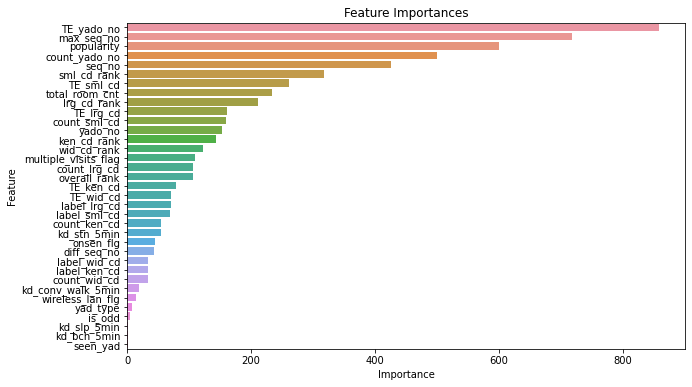

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

# 特徴量重要度の取得
feature_importances = model.feature_importances_

# 特徴量名とその重要度を DataFrame に変換
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
})

# 重要度で降順にソート
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 特徴量重要度のプロット
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()